In [1]:
#import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,r2_score,mean_absolute_error


# Data reading and EDA

In [2]:
holidays=pd.read_csv("holidays_events.csv")
#oil=pd.read_csv("oil.csv")
stores=pd.read_csv("stores.csv")
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [4]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [6]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [8]:
train=train.merge(stores,on='store_nbr',how='left')

In [9]:
print(holidays[['date','transferred']].duplicated().sum())
holidays.drop_duplicates(subset=['date','transferred'],keep='first',inplace=True)

38


In [10]:
train.date=train.date.astype('str')
holidays.date=holidays.date.astype('str')
#oil.date=oil.date.astype('str')

In [11]:
train=train.merge(holidays[['date','type','transferred']],on='date',how='left')
#train=train.merge(oil,on='date',how='left')


In [12]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,Holiday,False
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,Holiday,False
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,Holiday,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,Holiday,False
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,Holiday,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,Holiday,False
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,Holiday,False
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,Holiday,False
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,Holiday,False


In [13]:
train.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
transferred    2551824
dtype: int64

In [14]:
train['date']=pd.to_datetime(train['date'],format='%Y-%m-%d')

In [15]:
train.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

<AxesSubplot:xlabel='store_nbr'>

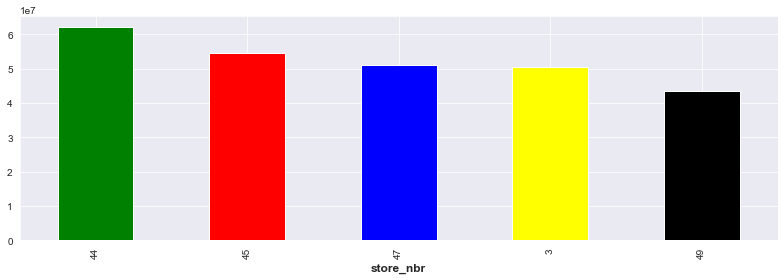

In [16]:
train.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head().plot(
    kind='bar',color=['green','red','blue','yellow','black'])

<AxesSubplot:xlabel='family'>

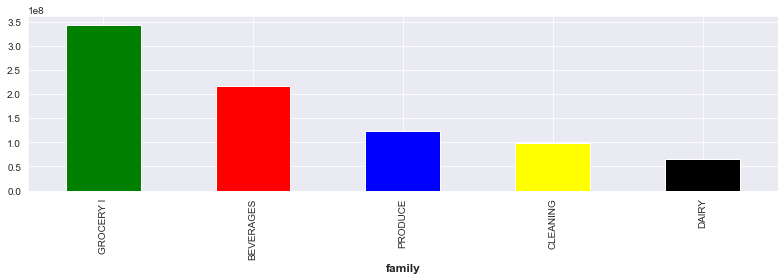

In [17]:
train.groupby('family')['sales'].sum().sort_values(ascending=False).head().plot(
    kind='bar',color=['green','red','blue','yellow','black'])

<AxesSubplot:xlabel='type_y'>

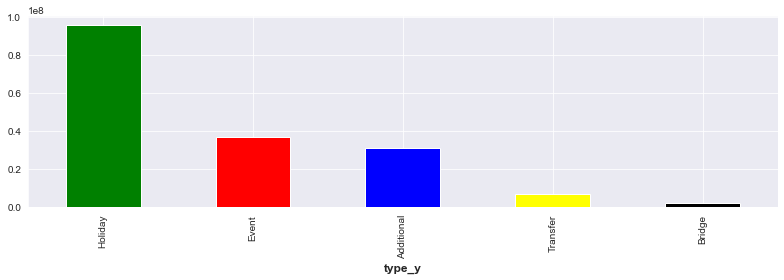

In [18]:
train.groupby('type_y')['sales'].sum().sort_values(ascending=False).head().plot(
    kind='bar',color=['green','red','blue','yellow','black'])

In [19]:
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,Holiday,False
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,Holiday,False
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,Holiday,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,Holiday,False
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,Holiday,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,Holiday,False
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,Holiday,False
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,Holiday,False
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,Holiday,False


In [20]:
forty_four=train[train.store_nbr==44]

In [21]:
forty_four

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,transferred
1254,1254,2013-01-01,44,AUTOMOTIVE,0.000,0,Quito,Pichincha,A,5,Holiday,False
1255,1255,2013-01-01,44,BABY CARE,0.000,0,Quito,Pichincha,A,5,Holiday,False
1256,1256,2013-01-01,44,BEAUTY,0.000,0,Quito,Pichincha,A,5,Holiday,False
1257,1257,2013-01-01,44,BEVERAGES,0.000,0,Quito,Pichincha,A,5,Holiday,False
1258,1258,2013-01-01,44,BOOKS,0.000,0,Quito,Pichincha,A,5,Holiday,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3000388,3000388,2017-08-15,44,POULTRY,909.194,0,Quito,Pichincha,A,5,Holiday,False
3000389,3000389,2017-08-15,44,PREPARED FOODS,329.522,0,Quito,Pichincha,A,5,Holiday,False
3000390,3000390,2017-08-15,44,PRODUCE,7239.617,10,Quito,Pichincha,A,5,Holiday,False
3000391,3000391,2017-08-15,44,SCHOOL AND OFFICE SUPPLIES,345.000,12,Quito,Pichincha,A,5,Holiday,False


In [22]:
forty_four.transferred.unique()

array([False, nan, True], dtype=object)

In [23]:
forty_four.groupby('family')['sales'].sum().sort_values(ascending=False)

family
GROCERY I                     1.638606e+07
BEVERAGES                     1.341786e+07
PRODUCE                       1.066606e+07
CLEANING                      4.308260e+06
DAIRY                         4.277954e+06
BREAD/BAKERY                  2.333058e+06
POULTRY                       2.086944e+06
MEATS                         1.636611e+06
EGGS                          1.091864e+06
FROZEN FOODS                  1.021094e+06
DELI                          1.004694e+06
PERSONAL CARE                 9.416410e+05
PREPARED FOODS                7.930117e+05
HOME CARE                     6.721670e+05
LIQUOR,WINE,BEER              5.539020e+05
SEAFOOD                       2.076526e+05
GROCERY II                    1.372800e+05
HOME AND KITCHEN I            1.348220e+05
HOME AND KITCHEN II           1.016780e+05
PLAYERS AND ELECTRONICS       4.431700e+04
CELEBRATION                   3.777300e+04
PET SUPPLIES                  3.414700e+04
LADIESWEAR                    3.344600e+04
LING

In [24]:
date_grp=forty_four.groupby("date")['sales'].sum()

In [25]:
date_grp.index.unique()

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1684, freq=None)

In [26]:
data=date_grp.reset_index()

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1684 non-null   datetime64[ns]
 1   sales   1684 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.4 KB


<AxesSubplot:title={'center':'Sales Trend over years'}, xlabel='date', ylabel='Sales'>

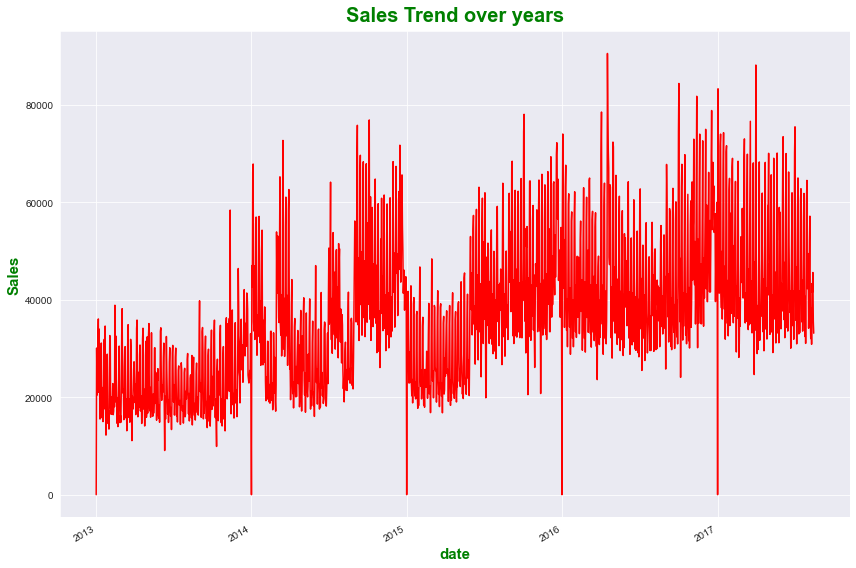

In [28]:
plt.figure(figsize=(12,8))
plt.title("Sales Trend over years",color='Green',fontsize=20)
plt.xlabel("Years",color='Green',fontsize=15)
plt.ylabel("Sales",color='Green',fontsize=15)
date_grp.plot(color='red')

In [29]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing

In [30]:
model=ExponentialSmoothing()

In [31]:
df=TimeSeries.from_dataframe(data,'date','sales',fill_missing_dates=True)

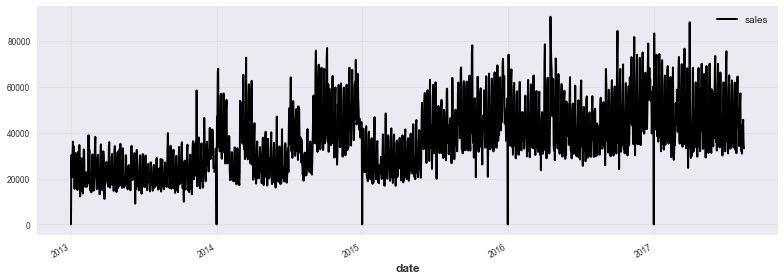

In [32]:
df.plot()

In [33]:
train, val = df[:-1400], df[-1400:]

In [34]:
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)
#Plotting the predictions
data.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

C:\Users\NITINS4.TTL\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ValueError: Date ordinal -14656994.046093125 converts to -38160-07-06T22:53:37.553920 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

<Figure size 792x288 with 1 Axes>

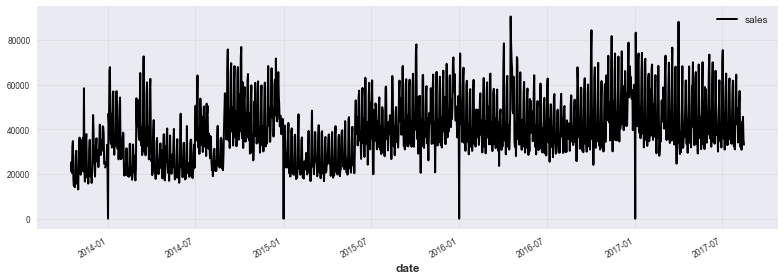

In [35]:
val.plot()

In [36]:
data.shape

(1684, 2)